In [1]:
from langgraph.graph import StateGraph,START,END,MessagesState
from langchain_openai import ChatOpenAI
from typing import TypedDict,Literal,Annotated
from dotenv import load_dotenv
from pydantic import BaseModel,Field
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage,HumanMessage,BaseMessage
from langgraph.checkpoint.memory import InMemorySaver

In [2]:
load_dotenv()

True

In [3]:
llm=ChatOpenAI()

In [4]:
class ChatState(MessagesState):
    summary:str

In [31]:
def chat_node(state: ChatState):
    messages = []

    if state["summary"]:
        messages.append({
            "role":"system",
            "content":f"converstion summary:\n{state['summary']}"
        })
    messages.extend(state["messages"])
    print(messages)
    response = llm.invoke(messages)
    return {"messages": [response]}


In [32]:
from langgraph.graph.message import RemoveMessage

In [33]:
def summarization_conversion(state:ChatState)->dict:
    existing_summary=state['summary']

    if existing_summary:
        prompt={
            f"Existing summary:\n{existing_summary}\n\n"
            "Extend the summary using using the new conversation above."
        }
    else:
        prompt="summarize the conversation above."

    messages_for_summary=state['messages']+[
        HumanMessage(content=prompt)
    ]
    response=llm.invoke(messages_for_summary)

    #keep only past 3 msg 
    messages_for_deletion=state['messages'][:-2]
    return {
        "summary":response.content,
        "messages":[RemoveMessage(id=m.id) for m in messages_for_deletion]
    }


In [ ]:
def should_summarize(state:ChatState):
    return len(state["messages"])>6


In [35]:
checkpointer=InMemorySaver()

In [43]:
graph=StateGraph(ChatState)

graph.add_node('chatnode',chat_node)
graph.add_node('summarize',summarization_conversion)

graph.add_edge(START,'chatnode')
graph.add_conditional_edges(
    "chatnode",should_summarize,
    {
        True:'summarize',
        False:END
    }
)

graph.add_edge('summarize',END)

graph=graph.compile(checkpointer=checkpointer)

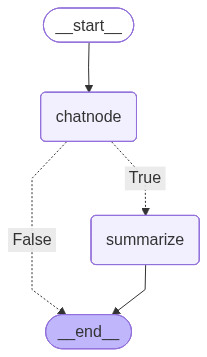

In [44]:
graph

In [45]:
config={"configurable":{"thread_id":"1"}}

In [46]:

def run_turn(text: str):
    out = graph.invoke({"messages": [HumanMessage(content=text)], "summary": ""}, config=config)
    return out

In [47]:
# gives the current version of the state
def show_state():
    snap = graph.get_state(config)
    vals = snap.values
    print("\n--- STATE ---")
    print("summary:", vals.get("summary", ""))
    print("num_messages:", len(vals.get("messages", [])))
    print("messages:")
    for m in vals.get("messages", []):
        print("-", type(m).__name__, ":", m.content[:80])

In [48]:
run_turn('Quantum Physics')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='14e19ebf-7a35-4cac-8905-998349b939ae'), HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='ba88c8e2-ebae-4c2c-afe0-64538426def8'), HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='9e820cd0-2acc-4b6b-b5f4-8d4280790822')]

--- STATE ---
summary: 
num_messages: 4
messages:
- HumanMessage : Quantum Physics
- HumanMessage : Quantum Physics
- HumanMessage : Quantum Physics
- AIMessage : Quantum physics, also known as quantum mechanics, is the branch of physics that 


In [49]:
run_turn('How is Albert Einstien related?')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='14e19ebf-7a35-4cac-8905-998349b939ae'), HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='ba88c8e2-ebae-4c2c-afe0-64538426def8'), HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='9e820cd0-2acc-4b6b-b5f4-8d4280790822'), AIMessage(content='Quantum physics, also known as quantum mechanics, is the branch of physics that studies the behavior of particles at the smallest scales, such as atoms and subatomic particles. It is a fundamental theory in modern physics that describes the nature and behavior of energy and matter on the atomic and subatomic levels. \n\nSome key concepts of quantum physics include wave-particle duality, superposition, and entanglement. Quantum physics has led to significant advancements in technology, such as the development of quantum computers and quantum cryptography. It also plays a vital role in under

In [50]:

run_turn('What are some of Einstien"s fampus work')
show_state()

[HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='14e19ebf-7a35-4cac-8905-998349b939ae'), HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='ba88c8e2-ebae-4c2c-afe0-64538426def8'), HumanMessage(content='Quantum Physics', additional_kwargs={}, response_metadata={}, id='9e820cd0-2acc-4b6b-b5f4-8d4280790822'), AIMessage(content='Quantum physics, also known as quantum mechanics, is the branch of physics that studies the behavior of particles at the smallest scales, such as atoms and subatomic particles. It is a fundamental theory in modern physics that describes the nature and behavior of energy and matter on the atomic and subatomic levels. \n\nSome key concepts of quantum physics include wave-particle duality, superposition, and entanglement. Quantum physics has led to significant advancements in technology, such as the development of quantum computers and quantum cryptography. It also plays a vital role in under

In [51]:

run_turn('Explain special theory of relativity')
show_state()

[HumanMessage(content='What are some of Einstien"s fampus work', additional_kwargs={}, response_metadata={}, id='9fc77a4f-e7dd-4c11-aa7f-adb4d183e1af'), AIMessage(content="Albert Einstein made numerous significant contributions to physics and science in general. Some of his most famous works include:\n\n1. Theory of Relativity: Einstein's theory of relativity consists of two main theories: special relativity and general relativity. Special relativity, published in 1905, introduced the famous equation E=mc^2, which describes the equivalency of energy and mass. General relativity, published in 1915, revolutionized our understanding of gravity and introduced the concept of spacetime curvature.\n\n2. Photoelectric Effect: In 1905, Einstein proposed a groundbreaking explanation of the photoelectric effect, showing that light can behave as both particles and waves. This work was instrumental in the development of quantum physics.\n\n3. Brownian Motion: In 1905, Einstein explained the random 